<a href="https://colab.research.google.com/github/zahradso/zahradso/blob/main/Stock_Price_Prediction_of_SLNO_using_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Background Information

The following project explores using LSTM to predict the price of Soleno Therapeutics, Ticker SLNO.

The data used has been taken from yahoo finance: https://finance.yahoo.com/quote/SLNO/.

# Introduction to Soleno

Soleno Therapeutics, Inc. (“Soleno”) (NASDAQ: SLNO), is a clinical-stage biopharmaceutical company developing novel therapeutics for the treatment of rare diseases. Soleno are curently researching and developing medicines to treat rare genetic disorders, beginning with Prader-Willi syndrome (PWS), a rare and life-threatening neurobehavioral, metabolic and endocrine disorder characterized by hyperphagia (insatiable hunger), neurocognitive and behavioral difficulties.

There are currently no approved therapeutics to treat hyperphagia, metabolic, cognitive function, or behavioral aspects of the disorder.
Soreno's lead product candidate, DCCR (Diazoxide Choline) has received Orphan Drug Designation for the treatment of PWS in the United States and in Europe.

# What is Long Short Term Memory (LSTM)?


Introduction to LSTM:
Long Short Term Memory (LSTM) is a type of recurrent neural network (RNN)designed by Hochreiter and Schmidhuber to tackle the problem of long-term dependencies of RNN. LSTMs are preferrable over traditional RNNs due to a range of reasons:

1)They are better at handling long-term dependencies due to their ability to remember information for extended periods of time.  

2)They are less susceptible to the vanishing gradient problem as they use a different kind of activation function, known as an LSTM cell, which helps to preserve information over long sequences.  

3)They are very efficient at modeling complex sequential data because they can learn high-level representations that capture the structure of the data.

LSTMs are specifically useful when handling sequential data, such as time series, speech, and text. LSTM networks are capable of learning long-term dependencies in sequential data, making them well suited for tasks such as language translation, speech recognition, and time series forecasting.


Structure Of LSTM:
The main difference between RNNs and LSTMs lie in their architecture. In an LSTM, the hidden layer is a gated cell. LSTMs consist of four layers that interact with one another in a way to produce the output of that cell along with the cell state. These two things are then passed onto the next hidden layer. Unlike RNNs which bear only a single neural net layer of tanh, LSTMs comprise three logistic sigmoid gates and one tanh layer. The gates introduced limit the information that is passed through the cell. They determine which part of the information will be needed by the next cell and which part is to be discarded. The output is usually in the range of 0-1 where ‘0’ means ‘reject all’ and ‘1’ means ‘include all’.

The gates are as follows: Forget Gate, Input Gate, Output Gate.

Forget Gate:


Input Gate:


Output Gate:



# Code Used

In [1]:
import pandas as pd
df = pd.read_csv('SLNO.csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-11-13,382.500,387.00,236.250,291.000,291.000,8367
1,2014-11-14,288.000,300.75,255.000,300.750,300.750,943
2,2014-11-17,291.750,303.00,279.750,303.000,303.000,561
3,2014-11-18,302.250,302.25,292.500,300.000,300.000,311
4,2014-11-19,291.375,299.25,270.000,292.500,292.500,348
...,...,...,...,...,...,...,...
2225,2023-09-19,4.700,4.74,4.370,4.510,4.510,97000
2226,2023-09-20,4.530,4.79,4.020,4.105,4.105,159000
2227,2023-09-21,4.180,4.35,3.960,4.110,4.110,116800
2228,2023-09-22,4.120,4.49,4.000,4.280,4.280,130700


In [2]:
# discard the other columns, focus only on data and close
df = df[['Date', 'Close']]
df

,Date,Close
0,2014-11-13,291.000
1,2014-11-14,300.750
2,2014-11-17,303.000
3,2014-11-18,300.000
4,2014-11-19,292.500
...,...,...
2225,2023-09-19,4.510
2226,2023-09-20,4.105
2227,2023-09-21,4.110
2228,2023-09-22,4.280


In [3]:
# convert date column to actual date as it is just a string

import datetime

def str_to_datetime(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)

datetime_object = str_to_datetime('2014-11-13')
datetime_object

datetime.datetime(2014, 11, 13, 0, 0)

In [4]:
# apply function to all data in table
df['Date'] = df['Date'].apply(str_to_datetime)
df['Date']

<ipython-input-4-955de5b0bebe>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = df['Date'].apply(str_to_datetime)


0      2014-11-13
1      2014-11-14
2      2014-11-17
3      2014-11-18
4      2014-11-19
          ...    
2225   2023-09-19
2226   2023-09-20
2227   2023-09-21
2228   2023-09-22
2229   2023-09-25
Name: Date, Length: 2230, dtype: datetime64[ns]

In [6]:
# make date column the index by removing the current column
df.index = df.pop('Date')
df


,Close
Date,
2014-11-13,291.000
2014-11-14,300.750
2014-11-17,303.000
2014-11-18,300.000
2014-11-19,292.500
...,...
2023-09-19,4.510
2023-09-20,4.105
2023-09-21,4.110


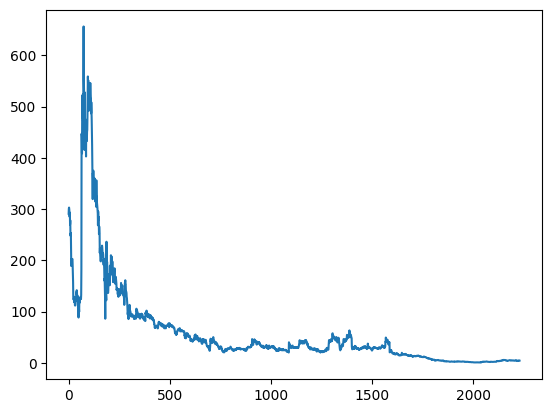

In [5]:
import matplotlib.pyplot as plt
plt.plot(df.index, df['Close'])

In [7]:
# convert to a supervised learning model for LSTM to be used
import numpy as np

def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date

  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)

    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))

    if last_time:
      break

    target_date = next_date

    if target_date == last_date:
      last_time = True

  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates

  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]

  ret_df['Target'] = Y

  return ret_df

# Start day second time around: '2021-03-25'
windowed_df = df_to_windowed_df(df,
                                '2021-03-25',
                                '2022-03-23',
                                n=3)
windowed_df
# target date column corresponds to target on same line
# so 2021-03-2025 corresponds to 18.9
# n=3 means the code gets the three previous values and then what the value actually is
# target column is the output we will need in future predictions

,Target Date,Target-3,Target-2,Target-1,Target
0,2021-03-25,22.500000,21.000000,20.250000,18.900000
1,2021-03-26,21.000000,20.250000,18.900000,19.049999
2,2021-03-29,20.250000,18.900000,19.049999,18.600000
3,2021-03-30,18.900000,19.049999,18.600000,19.049999
4,2021-03-31,19.049999,18.600000,19.049999,18.900000
...,...,...,...,...,...
247,2022-03-17,4.005000,4.065000,4.275000,4.635000
248,2022-03-18,4.065000,4.275000,4.635000,4.650000
249,2022-03-21,4.275000,4.635000,4.650000,4.800000
250,2022-03-22,4.635000,4.650000,4.800000,4.905000


In [8]:
# convert to numpy arrays to feed in tensorflow model
def windowed_df_to_date_X_y(windowed_dataframe):

  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))
  # the last 1 is because we are doing uin-variate forcasting depite having 3 inputs

  Y = df_as_np[:, -1] # want of all rows but only last column


  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape
# X.shape shows like this as it is 3 steps in the past for only 1 variable

((252,), (252, 3, 1), (252,))

In [ ]:
# setting up for TRAINING, VALIDATION and TESTING
q_80 = int(len(dates) * .8) # TRAINING
q_90 = int(len(dates) * .9) # VALIDATION

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]
dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

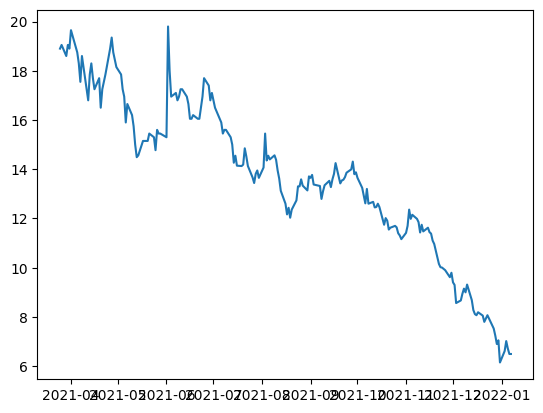

In [10]:
# TRAINING
q_80 = int(len(dates) * .8)
dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]
plt.plot(dates_train, y_train)


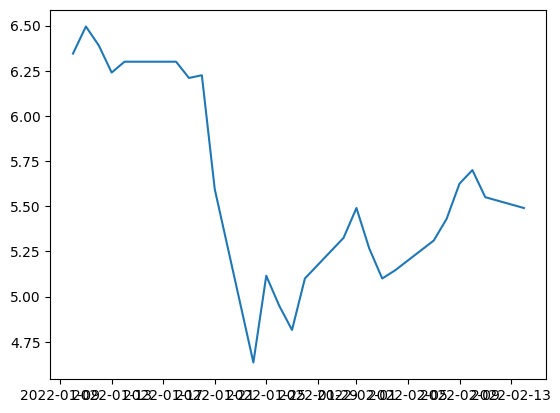

In [11]:
# VALIDATION
q_90 = int(len(dates) * .9) # VALIDATION
dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
plt.plot(dates_val, y_val)

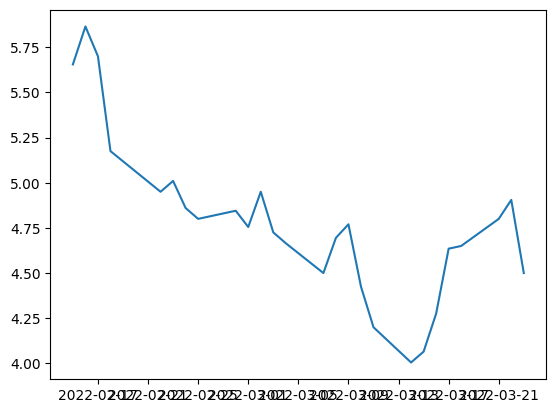

In [12]:
# TESTING
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]
plt.plot(dates_test, y_test)

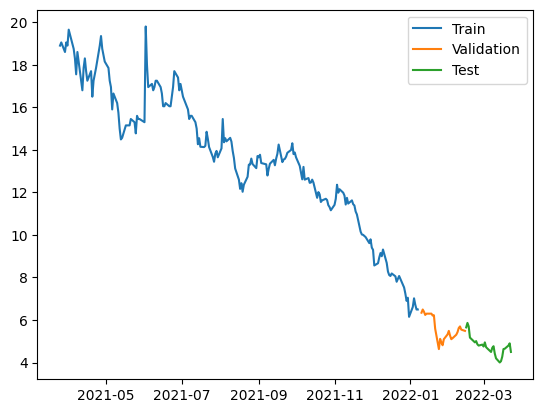

In [13]:
# ALL IN ONE PLOT
q_80 = int(len(dates) * .8) # TRAINING
q_90 = int(len(dates) * .9) # VALIDATION

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80] # 0%-80%
dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90] # 80%-90%
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:] # 90%-onwards

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [14]:
# optimimser model
from tensorflow.keras.optimizers import Adam
# sequential model built up of multiple layers
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

model = Sequential([layers.Input((3, 1)), # input data
                    layers.LSTM(64), # mid-range neuron layer -- don't want to be prone to overfitting
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)]) # output

model.compile(loss='mse', # mean squared error
              optimizer=Adam(learning_rate=0.001), # change around
              metrics=['mean_absolute_error']) # how much we are off by on average

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)
# care about the validation mean absolute error

Epoch 1/100
7/7 [==============================] - 4s 110ms/step - loss: 185.2636 - mean_absolute_error: 13.2337 - val_loss: 25.4901 - val_mean_absolute_error: 5.0224
Epoch 2/100
7/7 [==============================] - 0s 13ms/step - loss: 171.4813 - mean_absolute_error: 12.7012 - val_loss: 20.6097 - val_mean_absolute_error: 4.5123
Epoch 3/100
7/7 [==============================] - 0s 10ms/step - loss: 153.4767 - mean_absolute_error: 11.9773 - val_loss: 14.1297 - val_mean_absolute_error: 3.7290
Epoch 4/100
7/7 [==============================] - 0s 10ms/step - loss: 127.6810 - mean_absolute_error: 10.8486 - val_loss: 6.3706 - val_mean_absolute_error: 2.4849
Epoch 5/100
7/7 [==============================] - 0s 11ms/step - loss: 93.4269 - mean_absolute_error: 9.1355 - val_loss: 0.5212 - val_mean_absolute_error: 0.6386
Epoch 6/100
7/7 [==============================] - 0s 10ms/step - loss: 54.9830 - mean_absolute_error: 6.6910 - val_loss: 4.4276 - val_mean_absolute_error: 2.0696
Epoch 7/10

7/7 [==============================] - 1s 3ms/step


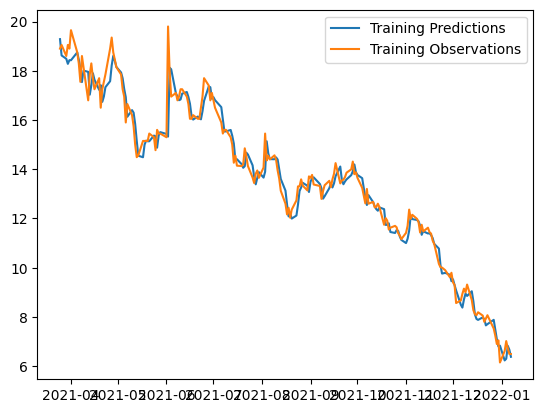

In [15]:
# plot TRAINING and ACTUAL on same graph
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

1/1 [==============================] - 0s 24ms/step


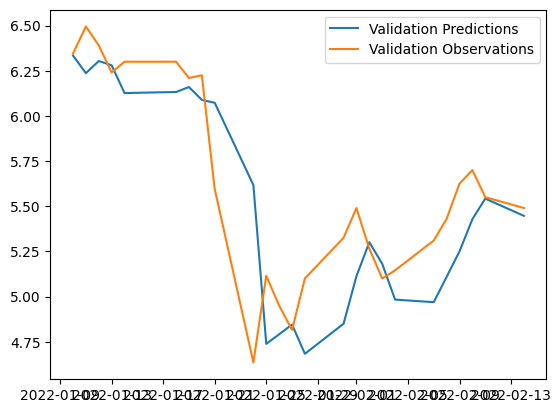

In [16]:
# plot VALIDATION and ACTUAL on same graph
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

1/1 [==============================] - 0s 27ms/step


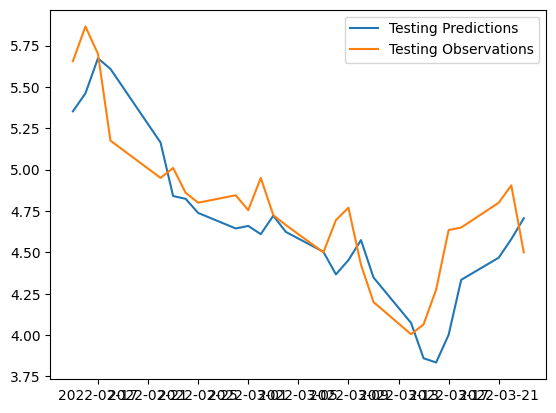

In [17]:
# plot TEST and ACTUAL on same graph
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

In [ ]:
# Plot EVERYTHING on same graph
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions',
            'Training Observations',
            'Validation Predictions',
            'Validation Observations',
            'Testing Predictions',
            'Testing Observations'])

Why would we end up with some problems?

LSTM models are bad at extrapolating